### Imports

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd

import fasttext
import re
import math

from nltk import corpus, stem

from collections import Counter

from wordcloud import WordCloud

### Load dataset

In [2]:
df = pd.read_json(
    "./data/data.zip",
    orient="records"
)

In [3]:
df["year"] = df["created.date-parts"].apply(lambda x: x[0][0] if isinstance(x, list) else None)

### Exploratory Data Analysis

#### 1) Titles

In [4]:
print(f"There are {df['title'].dropna().shape[0]} ({df['title'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null titles.")

There are 68211 (96.42%) non-null titles.


In [5]:
print("Titles that appear more than twice:")
display({
    key: value
    for key, value in df["title"].astype(str).value_counts(dropna=False).items()
    if value > 2
})

Titles that appear more than twice:


{'None': 2529,
 '[]': 177,
 'Editorial': 30,
 'Apresentação': 19,
 '[NO TITLE AVAILABLE]': 14,
 'TheHerschelVirgo Cluster Survey': 14,
 'Some Items of Interest to Process R&D Chemists and Engineers': 12,
 '': 7,
 'Abstracts': 7,
 'Preface': 5,
 'Groupware: Design, Implementation, and Use': 5,
 'The authors reply': 4,
 'EDITORIAL': 4,
 'Inductive Logic Programming': 3,
 'In Reply': 3,
 'Reply': 3,
 "Authors' response": 3,
 'Palavras dos Editores': 3,
 'APRESENTAÇÃO': 3}

#### 2) Abstract

In [6]:
print(f"There are {df['abstract'].dropna().shape[0]} ({df['abstract'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null abstracts.")

There are 17290 (24.44%) non-null abstracts.


#### 3) Subject

In [7]:
print(f"There are {df['subject'].dropna().shape[0]} ({df['subject'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null subjects.")

There are 57948 (81.92%) non-null subjects.


#### 4) Year

In [8]:
print(f"There are {df['year'].dropna().shape[0]} ({df['year'].dropna().shape[0]*100/df.shape[0]:.2f}%) non-null years.")

There are 68207 (96.42%) non-null years.


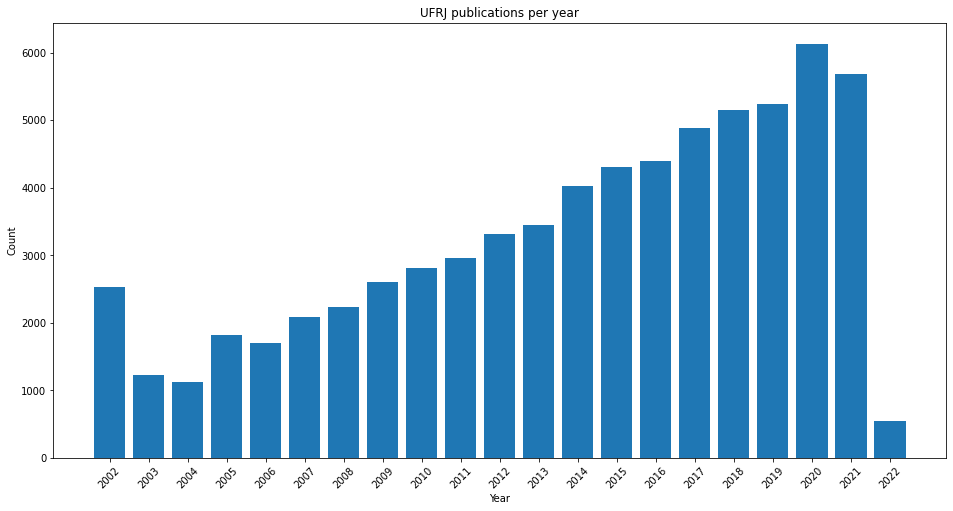

In [9]:
_ = df['year'].value_counts().to_dict()
fig, ax = plt.subplots(figsize=(16,8))
ax.bar(_.keys(), _.values())
ax.set_xticks(list(_.keys()))
ax.set_title("UFRJ publications per year")
ax.set_xlabel("Year")
ax.set_ylabel("Count");
plt.tick_params(axis="x", rotation=45)
plt.rcParams.update({'font.size': 18})
fig.savefig("./data/pub_per_year.pdf")

#### 5) Language

In [11]:
df["language"].value_counts(dropna=False)

en      44193
None    26226
pt        205
fr         57
es         37
de         21
ja          1
Name: language, dtype: int64

In [12]:
df.loc[pd.isna(df["language"])]["title"].dropna().sample(10)

6400     Color electron microprobe cathodoluminescence ...
47935    South American Indians: a case study in evolution
45349    O duplo fazer do gênero e do Estado: intercone...
42693    Can Simple GAs Solve Beehive Hidato Logic Puzz...
61039    Atopy patch test (APT) in the diagnosis of foo...
27151    Desempenho do Índice de Sustentabilidade Empre...
39273    Temporal distribution of ten calyptrate dipter...
57883    Reviewing the prognostic factors in myelomenin...
47364    ERIOCAULON L. from Brazil: An annotated checkl...
48731    1 MODELAGEM TERMODINÂMICA E CINÉTICA DE PRECIP...
Name: title, dtype: object

#### 6) Subjects

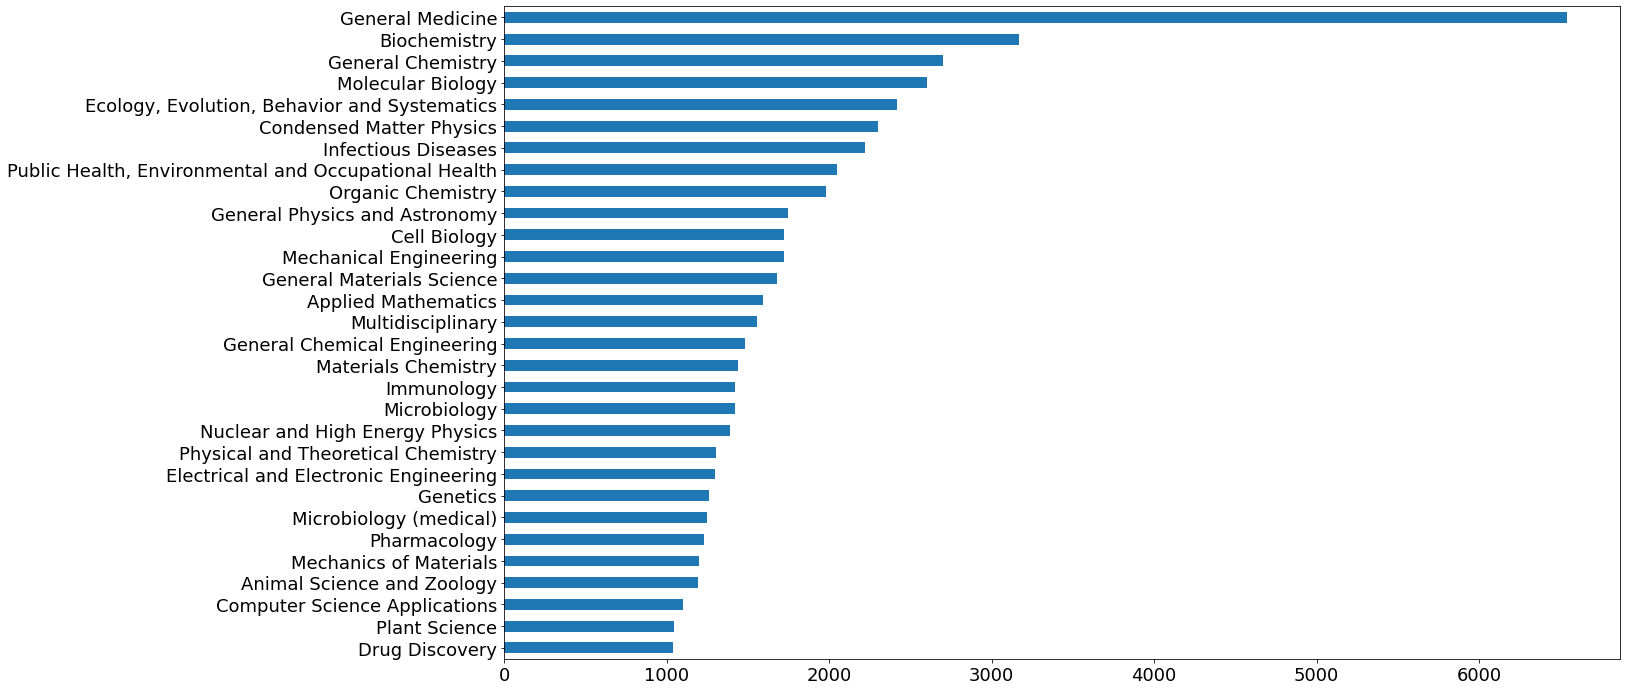

In [13]:
df.explode("subject")["subject"].value_counts().head(30).iloc[::-1].plot(kind="barh", figsize=(20,12));

In [14]:
len(df)

70740

### Data treatment

#### 1) Remove new lines

In [15]:
df_treated = df.replace(r'\n',' ', regex=True) 

#### 2) Remove HTML markup tags

In [16]:
df_treated['title'] = df_treated['title'].str.replace(r'<[^<>]*>', '', regex=True)

### 3) Remove null titles

In [17]:
df_treated = df_treated[df_treated['title'].notna()]

#### 4) Use `fasttext` to identify language of records

In [18]:
path_to_pretrained_model = 'data/lid.176.bin'
fmodel = fasttext.load_model(path_to_pretrained_model)

In [19]:
for index, row in df_treated.iterrows():
    row = row.copy()
    if (row['abstract'] != None):
        label, n = fmodel.predict(row['abstract'])
        if label != [] and n[0] > 0.9:
            df_treated.loc[index, 'language'] = label[0][9:11] #label do idioma: 'en', 'pt' etc

#### 5) Remove stopwords

In [20]:
stopwords = corpus.stopwords.words('english') + corpus.stopwords.words('portuguese')

df_treated['title'] = df_treated.title.str.replace("[^\w\s]", "", regex=True).str.lower()
df_treated['title'] = df_treated['title'].apply(lambda x: [item for item in x.split() if item not in stopwords])

#### 6) Apply Porter Stemmer to titles

In [21]:
stemmer = stem.PorterStemmer()
stemmer_dict = dict()

def stem_sentences(sentence):
    stemmed_tokens = list()
    for token in sentence:
        stemmed_token = stemmer.stem(token)
        stemmed_tokens.append(stemmed_token)
        stemmer_dict[stemmed_token] = token
    stemmerized_word = ' '.join(stemmed_tokens)
    return stemmerized_word

df_treated['title'] = df_treated['title'].apply(stem_sentences)

In [22]:
df_treated["language"].value_counts(dropna=False)

en      44193
None    23520
pt        205
fr         57
es         37
de         21
ja          1
Name: language, dtype: int64

#### 7) Filter for only English language titles

In [23]:
df_english = df_treated.loc[df['language'] == 'en']

#### 8) Filter only for papers with computation related subjects

In [58]:
comp_subjects = [
    'Computational Mathematics',
    'Computational Theory and Mathematics',
    'Computer Science Applications',
    'Information Systems',
    'Software',
    'Theoretical Computer Science',
    'Computer Networks and Communications',
    'Hardware and Architecture',
    'Information Systems and Management',
    'Management Information Systems',
    'Artificial Intelligence',
    'Computer Graphics and Computer-Aided Design',
    'Computer Vision and Pattern Recognition',
    'Computer Science (miscellaneous)',
    'Human-Computer Interaction'
]

df_comp = df_english.explode("subject")
df_comp["subject"] = df_comp["subject"].apply(lambda x: x if x in comp_subjects else float("NaN"))
df_comp = df_comp.loc[~pd.isna(df_comp["subject"])].drop_duplicates("title")

In [59]:
df_comp.shape[0]

2131

### Calculate TF-IDF for title words

#### 1) Define TF-IDF functions

In [60]:
def generate_dict(df):
    dict = {}
    for index, row in df.iterrows():
        try:
            dict[int(row['year'])] += row['title']
        except:
            dict[int(row['year'])] = row['title']
    return dict

def invert_tf(tf):
    itf = {}
    for doc, words in tf.items():
        for word in words:
            if word not in itf:
                itf[word] = {}
            try:
                itf[word][doc] = tf[doc][word]
            except:
                itf[word][doc] = {}
    return itf

def create_tf_idf(df):
        dict = generate_dict(df)
        inverted_list = {}

        for num, text in dict.items():
            word_tokens = text.split(' ')

            for word in word_tokens:
                if (word not in inverted_list):
                    inverted_list[word] = []
                inverted_list[word] = inverted_list[word] + [num]

        tf = {}
        for word, documents in inverted_list.items():
            for doc in documents:
                if (doc not in tf):
                    tf[doc] = {}
                try:
                    tf[doc][word] += 1
                except:
                    tf[doc][word] = 1
        
        idf = {}
        itf = invert_tf(tf)
        for word in itf:
            idf[word] = math.log(len(tf)/len(itf[word]))
        
        tf_idf = {}
        for doc, words in tf.items():
            for word in words:
                if doc not in tf_idf:
                    tf_idf[doc] = {}
                try:
                    tf_idf[doc][word] = tf[doc][word] * idf[word]
                except:
                    tf_idf[doc][word] = 0
        return tf_idf

#### 2) Calculate TF-IDF

In [61]:
tf_idf = create_tf_idf(df_comp)

In [62]:
tf_idf

{2013: {'high': 0.965080896043587,
  'costeffect': 2.3513752571634776,
  'ratio': 1.252762968495368,
  'giaompw1pw91631gdmpw1pw91631gd': 3.044522437723423,
  'scale': 3.758288905486104,
  'factor': 1.0986122886681098,
  '13c': 1.6582280766035324,
  'nuclear': 1.4350845252893227,
  'magnet': 1.9459101490553132,
  'reson': 1.252762968495368,
  'chemic': 2.505525936990736,
  'shift': 1.9459101490553132,
  'calcultangent': 3.044522437723423,
  'graeff': 3.044522437723423,
  'iterexpect': 3.044522437723423,
  'number': 1.678847363806268,
  'zero': 1.9459101490553132,
  'nonlinear': 0.30025037567094787,
  'equatorthogon': 3.044522437723423,
  'polynomi': 1.252762968495368,
  'respect': 1.9459101490553132,
  'class': 0.7419373447293773,
  'differenti': 0.4795730802618863,
  'opersensit': 3.044522437723423,
  'cluster': 1.4838746894587547,
  'gaussian': 3.8918202981106265,
  'mixtur': 4.974684229810597,
  'model': 0.0,
  'prior': 3.044522437723423,
  'distributeffici': 3.044522437723423,
  'sa

In [63]:
general_tf_idf = {}
for k in tf_idf.keys():
    for key, value in tf_idf[k].items():
        if key not in general_tf_idf.keys():
            general_tf_idf[key] = value

In [64]:
general_tf_idf

{'high': 0.965080896043587,
 'costeffect': 2.3513752571634776,
 'ratio': 1.252762968495368,
 'giaompw1pw91631gdmpw1pw91631gd': 3.044522437723423,
 'scale': 3.758288905486104,
 'factor': 1.0986122886681098,
 '13c': 1.6582280766035324,
 'nuclear': 1.4350845252893227,
 'magnet': 1.9459101490553132,
 'reson': 1.252762968495368,
 'chemic': 2.505525936990736,
 'shift': 1.9459101490553132,
 'calcultangent': 3.044522437723423,
 'graeff': 3.044522437723423,
 'iterexpect': 3.044522437723423,
 'number': 1.678847363806268,
 'zero': 1.9459101490553132,
 'nonlinear': 0.30025037567094787,
 'equatorthogon': 3.044522437723423,
 'polynomi': 1.252762968495368,
 'respect': 1.9459101490553132,
 'class': 0.7419373447293773,
 'differenti': 0.4795730802618863,
 'opersensit': 3.044522437723423,
 'cluster': 1.4838746894587547,
 'gaussian': 3.8918202981106265,
 'mixtur': 4.974684229810597,
 'model': 0.0,
 'prior': 3.044522437723423,
 'distributeffici': 3.044522437723423,
 'sampl': 0.8472978603872037,
 'scheme': 

In [142]:
def generate_wordcloud(l, label):
    words = " ".join(s for s in l)

    wordcloud = WordCloud(background_color="white",width=1600, height=800).generate(words)
    wordcloud.to_file("./data/wc_{}.pdf".format(label))
    
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()
    plt.imshow(wordcloud)

In [70]:
common_list = []
c = Counter(general_tf_idf)
for i in range(1,41):
    common_list += [c.most_common()[-i][0]] * int(1000-(c.most_common()[-i][1]*1000))
    common_list.append(c.most_common()[-i][0])

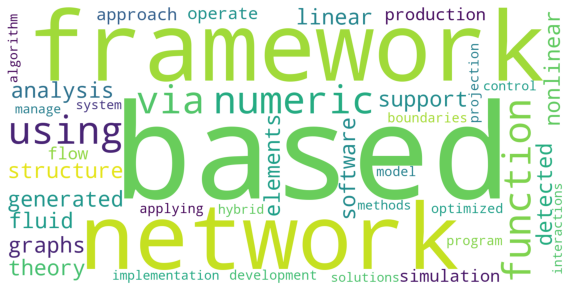

In [144]:
generate_wordcloud([stemmer_dict[i] for i in set(common_list)], "general")

2002
2005
2008
2011
2014
2017
2020


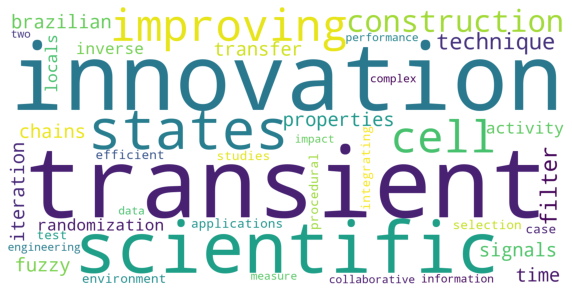

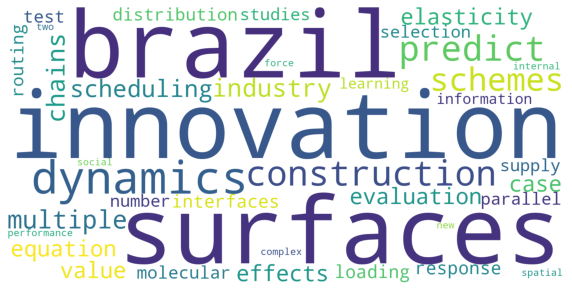

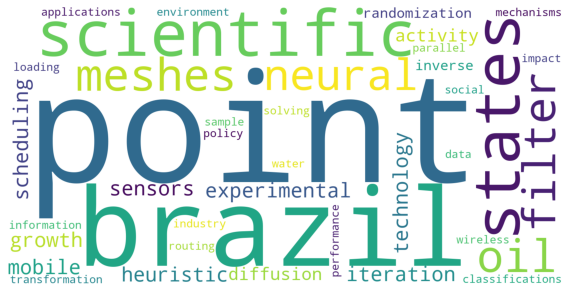

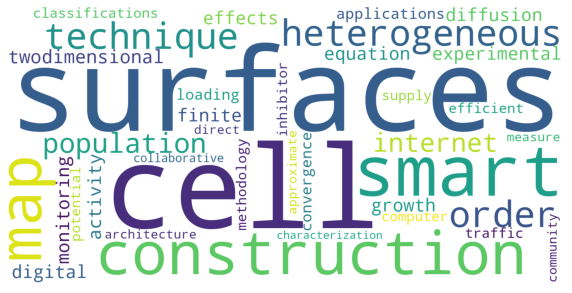

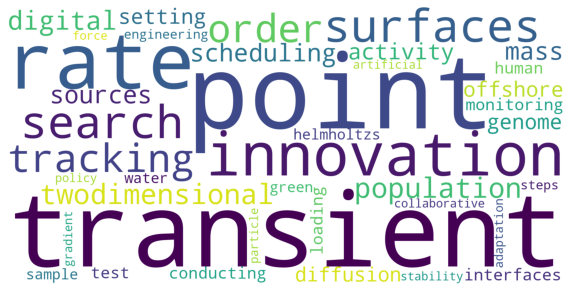

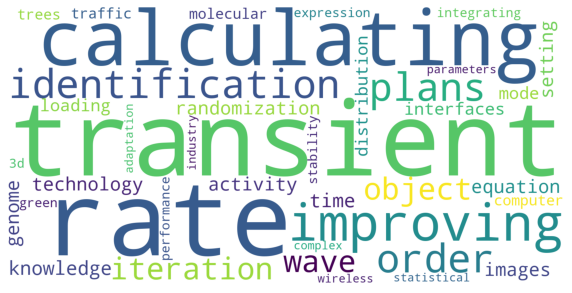

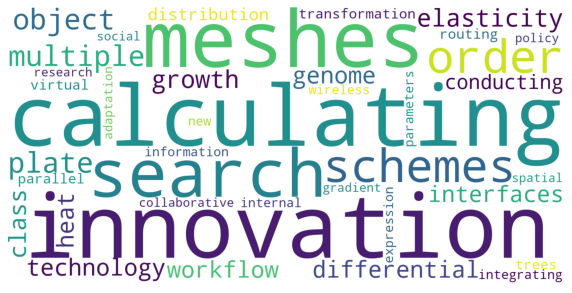

In [145]:
cloud_dict = dict()

for year in range(2002,2022,3):
    c = Counter(
        {k: tf_idf[year].get(k, 0) + tf_idf[year+1].get(k, 0) + tf_idf[year+2].get(k, 0) for k in set(tf_idf[year]) | set(tf_idf[year+1]) | set(tf_idf[year+2])}
    )
    l = []
    count = 0
    i = 0
    while count < 40:
        if c.most_common()[-i][0] not in common_list:
            l += [c.most_common()[-i][0]] * int(1000-(c.most_common()[-i][1]*1000))
            count += 1
        i += 1
    print(year)
    stemmer_l = [stemmer_dict[i] for i in set(l)]
    cloud_dict[year] = set(stemmer_l)
    generate_wordcloud(stemmer_l, year)

In [138]:
# [2002, 2005, 2008, 2011, 2014, 2017, 2020]
for i in [2002, 2005, 2008, 2011, 2014, 2017]:
    print(i)
    print(cloud_dict[i + 3] - cloud_dict[i])
    print()

2002
{'routing', 'brazil', 'supply', 'industry', 'predict', 'equation', 'interfaces', 'elasticity', 'force', 'schemes', 'surfaces', 'evaluation', 'molecular', 'value', 'learning', 'response', 'parallel', 'multiple', 'dynamics', 'number', 'distribution', 'scheduling', 'loading', 'effects', 'new', 'social', 'spatial', 'internal'}

2005
{'point', 'scientific', 'oil', 'classifications', 'filter', 'diffusion', 'iteration', 'neural', 'sample', 'growth', 'meshes', 'technology', 'states', 'applications', 'transformation', 'solving', 'heuristic', 'experimental', 'policy', 'sensors', 'water', 'mechanisms', 'inverse', 'activity', 'data', 'environment', 'wireless', 'randomization', 'mobile', 'impact'}

2008
{'supply', 'heterogeneous', 'cell', 'smart', 'map', 'order', 'methodology', 'internet', 'equation', 'characterization', 'collaborative', 'digital', 'twodimensional', 'population', 'architecture', 'surfaces', 'monitoring', 'finite', 'traffic', 'potential', 'measure', 'inhibitor', 'approximate', 

In [80]:
cloud_dict.keys()

dict_keys([2002, 2005, 2008, 2011, 2014, 2017, 2020])